In [3]:
import cv2
import sys
import glob
import numpy as np
import dlib
import matplotlib.patches as patches
from align import AlignDlib 
import matplotlib.pyplot as plt
import model
import matplotlib

Using TensorFlow backend.


In [4]:
def check_dim(img):
    if img.ndim == 3:
        img = np.expand_dims(img, axis=0)
    return img

def align_image(img):
    alignment = AlignDlib('models/landmarks.dat')
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

def to_vector_embedded(img):
    img = check_dim(img)
    embedded = np.zeros((img.shape[0], 128))

    for i, m in enumerate(img):
        try:
            images = align_image(m)
            images = (images / 255.).astype(np.float32)
        except:
            images = cv2.resize(m,(96,96))
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(images, axis=0))[0]
    return embedded

def prepare_database():
    label = []
    foto = []
    
    for img in glob.glob('database/*.jpg'):
        try:
            label.append(str(img).split('/')[1].split('.')[0])
        except:
            label.append(str(img).split('\\')[1].split('.')[0])
        image = cv2.imread(img)
        image = cv2.resize(image, (250,250))
        foto.append(np.array(image))
    return np.array(foto), np.array(label)

def webcam_face_detection():
    video_capture = cv2.VideoCapture( "http://192.168.43.61:8080/video")
    detector = dlib.get_frontal_face_detector()

    while True:
        ret, frame = video_capture.read()

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)
        for face in rects:
            x = face.left()
            y = face.top() 
            w = face.right() - face.left()
            h = face.bottom() - face.top()
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 0)
            face_region= frame[y:y+h, x:x+w]

        cv2.imshow('Press "q" if your face has detected', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.imwrite('only_face.jpg', face_region)
            break

    video_capture.release()
    cv2.destroyAllWindows()
    return face_region
    
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def nearest_distance(new_face):
    dist = []
    for i in range(foto.shape[0]):
        dist.append(distance(new_face, embedded[i]))
    
    idx_min = np.array(dist).argmin()
    dist_min = dist[idx_min] 
    show_pair(new_face, idx_min)

    return idx_min, dist_min
    
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle('Most similar face with '+ str(label[idx2]) +' \n Not you?')
    plt.subplot(121)
    plt.imshow(face_region)
    plt.subplot(122)
    plt.imshow(align_image(foto[idx2]))
    plt.xlabel(label[idx2])
    plt.show()

nn4_small2_pretrained = model.create_model()
nn4_small2_pretrained.load_weights('models/nn4.small2.v1.h5')
    

Prepare database
Find vector for images in database
Start camera, please enter "q" if system has detected the face
Start predicting...


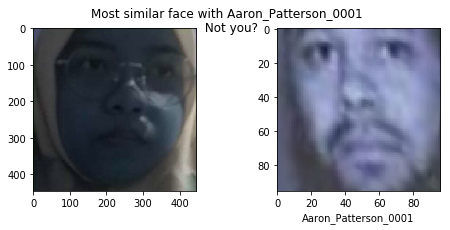

new face match to Aaron_Patterson_0001 with distance = 1.12436188799


In [9]:
if __name__ == "__main__":
    print('Prepare database')
    foto, label = prepare_database()
    print('Find vector for images in database')
    embedded = to_vector_embedded(foto)
    print('Start camera, please enter "q" if system has detected the face')
    face_region = webcam_face_detection()
    print('Start predicting...')
    try:
        new_face = to_vector_embedded(face_region)
        match, dist = nearest_distance(new_face)
        print('new face match to ' + label[match] + ' with distance = ' + str(dist))
    except:
        print('Failed. Nothing to predict.')

### Images in database

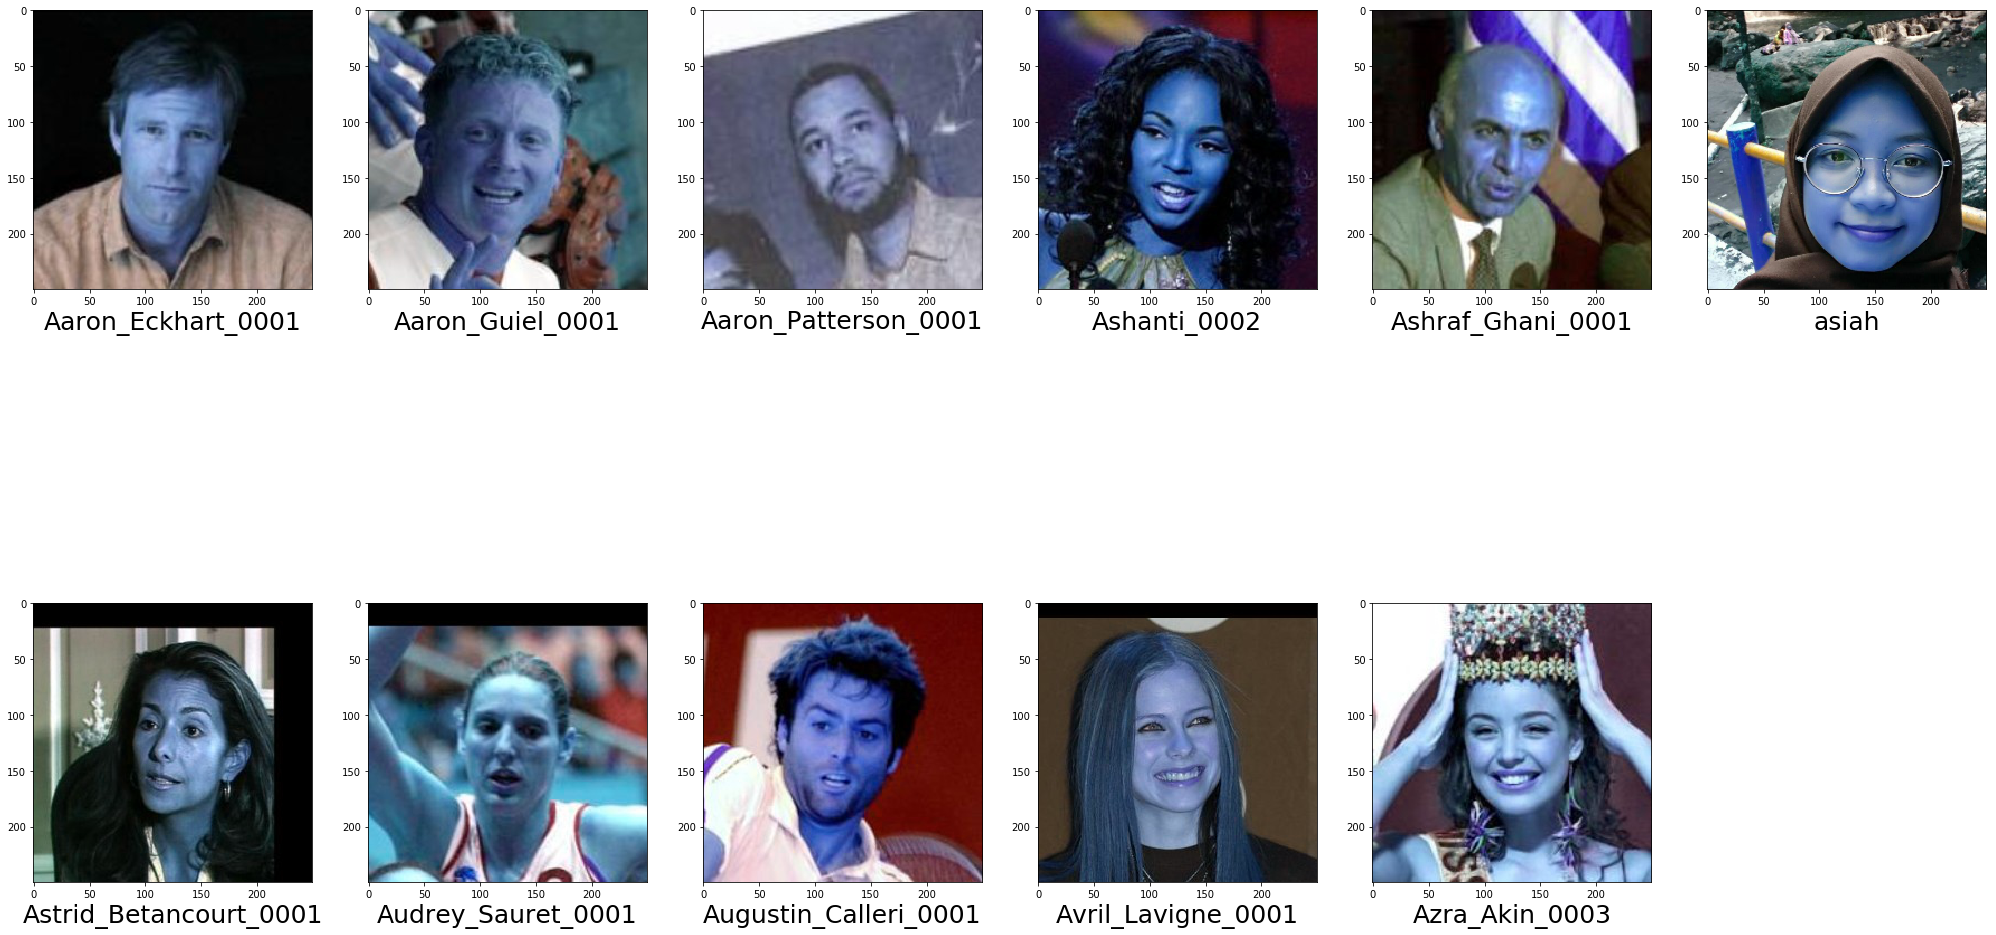

In [17]:
fig = plt.figure(figsize=(35,20))
count = 1
for i in range(11):
    fig.add_subplot(2,6,count)
    plt.imshow(foto[i], cmap=None)
    plt.xlabel(label[i], fontsize=25)
    count += 1
    plt.grid(False)
plt.show()